# **PDE Equation With 2 Variables**

The **PDE Equation With 2 Variables** is given by:

$$
\frac{\partial u}{\partial t}(x,t) = c \frac{\partial^2 u}{\partial x^2} +\sigma u(1-\frac{u}{k}) - (1+ \alpha v)uv  , \quad x \in [-50,50], \quad t \geq 0
$$

$$
\frac{\partial v}{\partial t}(x,t) = c_1 \frac{\partial^2 u}{\partial x^2} + (1+ \alpha v)uv - v
$$

with the **boundary conditions**:

$$
\frac{\partial u}{\partial x} = 0 = \frac{\partial v}{\partial x},
$$

$$
where \    \ k = 0.65 \ , \alpha = 10 \ ,  \sigma = 0.92 \ , \ c = 1 \ , \ c_1 = 0.18 \
$$

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from pyDOE2 import lhs  # Use pyDOE2 instead of pyDOE

In [2]:
# Set device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
# Define the physics-informed neural network (PINN)
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),  # Input: (x, t)
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 2)   # Output: (u, v)
        )

    def forward(self, x, t):
        inputs = torch.cat((x, t), dim=1)
        return self.net(inputs)

In [4]:
# Define parameters
k, alpha, sigma, c, c_1 = 0.65, 10, 0.92, 1, 0.18

In [5]:
# Define loss function (PDE residuals)
def pde_loss(model, x, t):
    x.requires_grad = True
    t.requires_grad = True
    u_v = model(x, t)
    u, v = u_v[:, 0:1], u_v[:, 1:2]

    # Compute derivatives using autograd
    u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0], 
                               x, torch.ones_like(u), create_graph=True)[0]
    v_t = torch.autograd.grad(v, t, torch.ones_like(v), create_graph=True)[0]
    v_xx = torch.autograd.grad(torch.autograd.grad(v, x, torch.ones_like(v), create_graph=True)[0], 
                               x, torch.ones_like(v), create_graph=True)[0]

    # PDE residuals
    f1 = u_t - c * u_xx - sigma * u * (1 - u/k) + (1 + alpha * v) * u * v
    f2 = v_t - c_1 * v_xx - (1 + alpha * v) * u * v + v

    return torch.mean(f1**2) + torch.mean(f2**2)

In [6]:
# Compute boundary condition loss (Neumann BCs: du/dx = 0, dv/dx = 0)
def boundary_loss(model, x_bc, t_bc):
    x_bc.requires_grad = True
    t_bc.requires_grad = True

    u_v_bc = model(x_bc, t_bc)
    u_bc, v_bc = u_v_bc[:, 0:1], u_v_bc[:, 1:2]

    # Compute spatial derivatives
    u_x = torch.autograd.grad(u_bc, x_bc, torch.ones_like(u_bc), create_graph=True)[0]
    v_x = torch.autograd.grad(v_bc, x_bc, torch.ones_like(v_bc), create_graph=True)[0]

    return torch.mean(u_x**2) + torch.mean(v_x**2)  # Enforce zero derivative

In [7]:
# Initial Condition Loss Function
def initial_loss(model, x_ic, t_ic, u0, v0):
    u_v_ic = model(x_ic, t_ic)  # Get model predictions at (x, t=0)
    u_ic, v_ic = u_v_ic[:, 0:1], u_v_ic[:, 1:2]  # Extract u and v

    return torch.mean((u_ic - u0) ** 2) + torch.mean((v_ic - v0) ** 2)  # MSE loss for ICs

In [8]:
def total_loss(model, x_pde, t_pde, x_bc_left, t_bc, x_bc_right, x_ic, t_ic, u0, v0):
    loss_pde = pde_loss(model, x_pde, t_pde)  # PDE loss
    loss_bc = boundary_loss(model, x_bc_left, t_bc) + boundary_loss(model, x_bc_right, t_bc)  # BC loss
    loss_ic = initial_loss(model, x_ic, t_ic, u0, v0)  # IC loss
    
    return loss_pde + loss_bc + loss_ic  # Combine all losses

In [9]:
# Load the .mat file
mat_data = scipy.io.loadmat('reaction_diffusion_data.mat')

# Display the available keys in the file
print(mat_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'U', 'V', 't', 'x'])


In [10]:
# Extract data
U = mat_data['U']
V = mat_data['V']
x = mat_data['x']
t = mat_data['t']

# Print shapes of the variables
print("U shape:", U.shape)
print("V shape:", V.shape)
print("x shape:", x.shape)
print("t shape:", t.shape)

U shape: (400, 1001)
V shape: (400, 1001)
x shape: (1, 1001)
t shape: (1, 401)


In [30]:
# generate collocation points inside the domain
lb = np.array([-50.0, 0.0])
ub = np.array([50.0, 20.0])
N_f = 1000
X_f = lb + (ub-lb)*lhs(2, N_f)

# Convert to PyTorch tensors
X_f_tensor = torch.tensor(X_f, dtype=torch.float32)

# Split into X and T components
X_train = X_f_tensor[:, 0:1]   # shape (1000, 1)
T_train = X_f_tensor[:, 1:2]   # shape (1000, 1)

# Check shapes
print("X_train:", X_train.shape)
print("T_train:", T_train.shape)

X_train: torch.Size([1000, 1])
T_train: torch.Size([1000, 1])


In [48]:
# Number of initial condition points
N0 = 200
idx_x = np.random.choice(x.shape[1], N0, replace=False)
x0 = x[:,idx_x]
x0 = x0.T  # Transpose to shape (200, 1)
# Convert to torch tensor
x0_tensor = torch.tensor(tb, dtype=torch.float32)

t_ic = torch.zeros_like(x_ic).to(device)  # t = 0
U0 = U[0:1,idx_x]
V0 = V[0:1,idx_x]

U0 = U0.T  # Transpose to shape (200, 1)
# Convert to torch tensor
U0_tensor = torch.tensor(U0, dtype=torch.float32)

v0 = v0.T  # Transpose to shape (200, 1)
# Convert to torch tensor
V0_tensor = torch.tensor(v0, dtype=torch.float32)

In [33]:
# Generate boundary condition data
N_b = 200
idx_t = np.random.choice(t.shape[1], N_b, replace=False)
tb = t[:,idx_t]
tb = tb.T  # Transpose to shape (200, 1)
# Convert to torch tensor
tb_tensor = torch.tensor(tb, dtype=torch.float32)

x_bc_left = torch.full_like(t_bc, -50.0).to(device)  # x = -50
x_bc_right = torch.full_like(t_bc, 50.0).to(device)  # x = 50

In [37]:
# Initialize model, optimizer
model = PINN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [49]:
# Training loop
epochs = 5000
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = total_loss(model, X_train, T_train, x_bc_left, tb_tensor, x_bc_right, x0_tensor, t_ic, U0_tensor, V0_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 0.039228130131959915
Epoch 500, Loss: 1.0099697647092398e-05
Epoch 1000, Loss: 4.0743984754954e-06
Epoch 1500, Loss: 3.113006187049905e-06
Epoch 2000, Loss: 2.7066905659012264e-06
Epoch 2500, Loss: 2.4644782570248935e-06
Epoch 3000, Loss: 5.024580786994193e-06
Epoch 3500, Loss: 1.5813791833352298e-05
Epoch 4000, Loss: 2.2060173705540365e-06
Epoch 4500, Loss: 2.182581738452427e-06


In [50]:
# Convert to PyTorch tensor and reshape
x_tensor = torch.tensor(x, dtype=torch.float32).flatten()  # (1001,)
x_tensor = x_tensor.view(1001, 1)  # Resize to (1001,1)
print("x shape:", x_tensor.shape)

x shape: torch.Size([1001, 1])


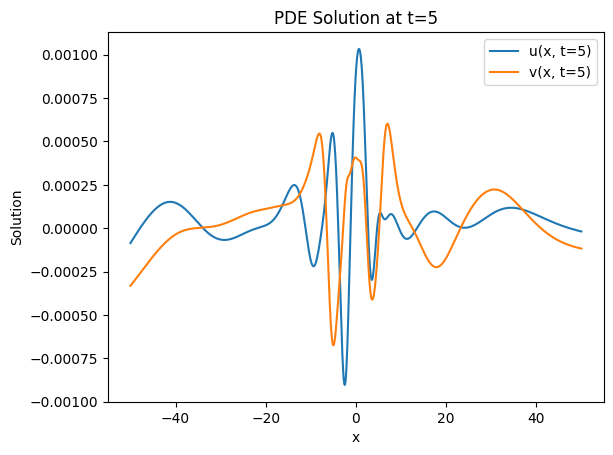

In [51]:
# Plot solution at t = 5
# x_test = torch.linspace(-50, 50, 100).reshape(-1, 1).to(device)
# t_test = torch.full_like(x_test, 5.0)  # Evaluate at t=5


t_tensor = torch.full_like(x_tensor, 5.0)  # Evaluate at t=5
u_v_pred = model(x_tensor, t_tensor).detach().cpu().numpy()

plt.plot(x_tensor.cpu().numpy(), u_v_pred[:, 0], label="u(x, t=5)")
plt.plot(x_tensor.cpu().numpy(), u_v_pred[:, 1], label="v(x, t=5)")
plt.legend()
plt.xlabel("x")
plt.ylabel("Solution")
plt.title("PDE Solution at t=5")
plt.show()

In [52]:
U_exact = U[11,:]
print("U shape:", U_exact.shape)

U shape: (1001,)


In [53]:
V_exact = V[11,:]
print("V shape:", V_exact.shape)

V shape: (1001,)


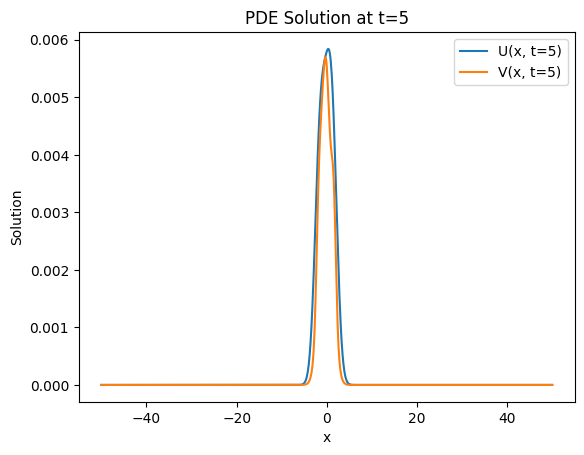

In [54]:
plt.plot(x_tensor.cpu().numpy(), U_exact, label="U(x, t=5)")
plt.plot(x_tensor.cpu().numpy(), V_exact, label="V(x, t=5)")
plt.legend()
plt.xlabel("x")
plt.ylabel("Solution")
plt.title("PDE Solution at t=5")
plt.show()

In [21]:
# Generate training data
N_train = 1000  # Number of PDE training points
x_train = torch.FloatTensor(np.random.uniform(-50, 50, (N_train, 1))).to(device)
t_train = torch.FloatTensor(np.random.uniform(0, 10, (N_train, 1))).to(device)

In [31]:
t_bc.shape

torch.Size([200, 1])

In [24]:
# Generate boundary condition data
N_bc = 200  # Number of boundary points
t_bc = torch.FloatTensor(np.random.uniform(0, 10, (N_bc, 1))).to(device)
x_bc_left = torch.full_like(t_bc, -50.0).to(device)  # x = -50
x_bc_right = torch.full_like(t_bc, 50.0).to(device)  # x = 50

In [40]:
# Number of initial condition points
N_ic = 200

# Generate random x in the domain [-50, 50] x [-50, 50]
x_ic = torch.FloatTensor(np.random.uniform(-50, 50, (N_ic, 1))).to(device)
t_ic = torch.zeros_like(x_ic).to(device)  # t = 0

# Generate random perturbations η1(x) and η2(x)
eta1 = torch.FloatTensor(np.random.randn(N_ic, 1)).to(device)  # Standard normal noise
eta2 = torch.FloatTensor(np.random.randn(N_ic, 1)).to(device)  # Standard normal noise

# Define initial values u* and v*
u_star = 0
v_star = 0

# Compute perturbed initial conditions
u0_ = u_star + 0.001 * np.abs(eta1)  # Initial condition for u
v0_ = v_star + 0.001 * np.abs(eta2)  # Initial condition for v

u0_.shape

torch.Size([200, 1])

In [15]:
# Save trained model
# torch.save(model.state_dict(), "pde_pinn_model.pth")

x shape: torch.Size([1001, 1])


In [19]:
# Convert to PyTorch tensor and reshape
# t_tensor = torch.tensor(t, dtype=torch.float32).flatten()  # (401,)
# t_tensor = t_tensor.view(401, 1)  # Resize to (401,1)
# print("t shape:", t_tensor.shape)

U shape: (1001,)


V shape: (1001,)


In [23]:
u_v_pred[:, 0].shape

(1001,)

In [24]:
u_v_pred[:, 1].shape

(1001,)

In [30]:
# plt.plot(x_tensor.cpu().numpy(), U, label="u(x, t=5)")
# plt.plot(x_tensor.cpu().numpy(), V, label="v(x, t=5)")
# plt.legend()
# plt.xlabel("x")
# plt.ylabel("Solution")
# plt.title("PDE Solution at t=5")
# plt.show()

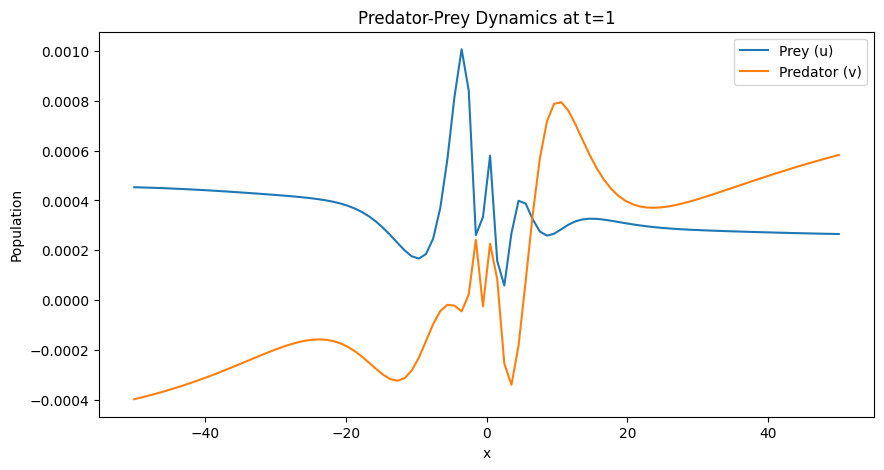

In [30]:
# Generate test points for prediction
x_test = torch.linspace(-50, 50, 100).reshape(-1, 1).to(device)
t_test = torch.FloatTensor([[1.0]] * 100).to(device)  # Fixed t=1

# Predict u and v
with torch.no_grad():
    uv_pred = model(x_test, t_test)
    u_pred, v_pred = uv_pred[:, 0].cpu().numpy(), uv_pred[:, 1].cpu().numpy()

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(x_test.cpu().numpy(), u_pred, label="Prey (u)")
plt.plot(x_test.cpu().numpy(), v_pred, label="Predator (v)")
plt.xlabel("x")
plt.ylabel("Population")
plt.legend()
plt.title("Predator-Prey Dynamics at t=1")
plt.show()


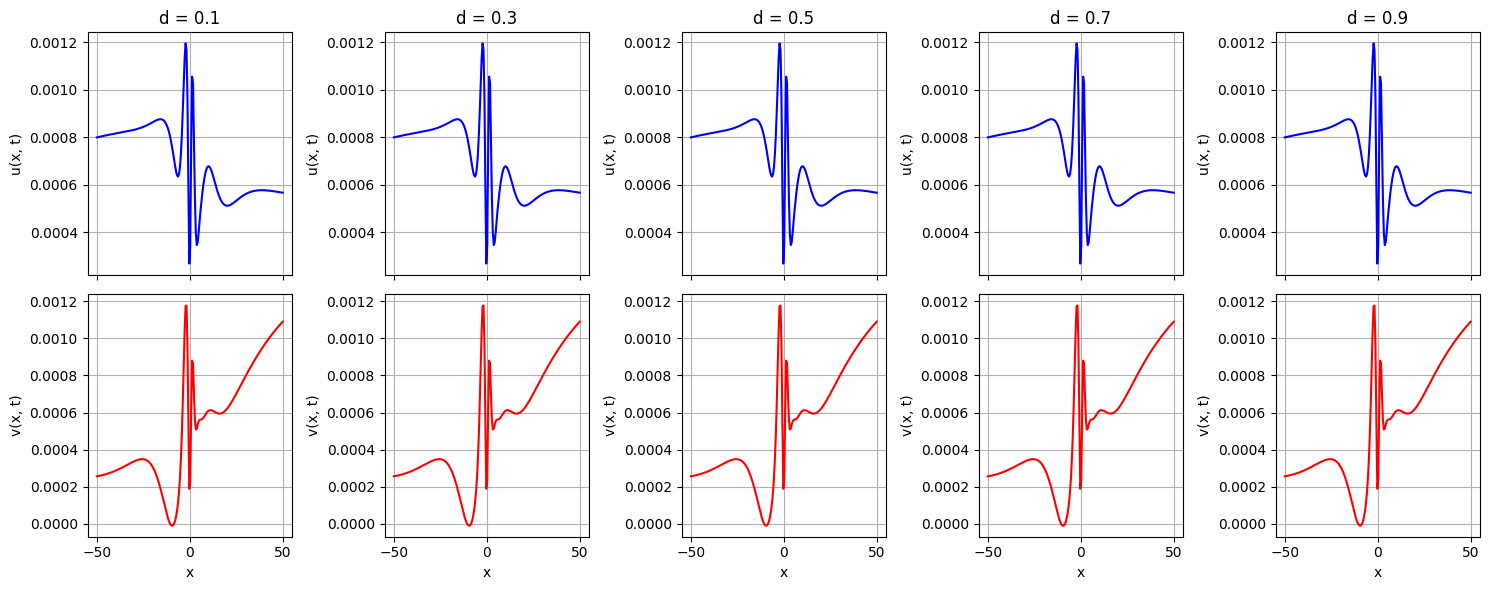

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Define spatial domain
x = torch.linspace(-50, 50, 200).reshape(-1, 1)  # 1D spatial domain with 200 points
t = torch.full_like(x, 0.0)  # Fix time at t=0

# # Load trained PINN model (Ensure you have trained and saved your model)
# model = PINN()
# model.load_state_dict(torch.load("pinn_model.pth"))  # Load trained model
# model.eval()

# Different d-values as in the reference paper
# d_values = [0.265, 0.24, 0.23, 0.18, 0.15]

d_values = [0.1, 0.3, 0.5, 0.7, 0.9]

# Create figure with subplots (similar layout to the reference image)
fig, axes = plt.subplots(2, len(d_values), figsize=(15, 6), sharex=True)

for i, d in enumerate(d_values):
    # Predict u(x, t) and v(x, t) using the trained PINN model
    with torch.no_grad():
        predictions = model(x, t)
        u_pred = predictions[:, 0].numpy()  # Extract 'u' (prey)
        v_pred = predictions[:, 1].numpy()  # Extract 'v' (predator)
    
    # Plot prey population (upper row)
    ax = axes[0, i]
    ax.plot(x.numpy(), u_pred, color='b')
    ax.set_title(f"d = {d}")
    ax.set_ylabel("u(x, t)")
    ax.grid()

    # Plot predator population (lower row)
    ax = axes[1, i]
    ax.plot(x.numpy(), v_pred, color='r')
    ax.set_ylabel("v(x, t)")
    ax.set_xlabel("x")
    ax.grid()

plt.tight_layout()
plt.show()